# Comparing Demographic Trends in Australian and New Zealand Census Data
### CITS2402 - Introduction to Data Science

**Date Created:** October 5, 2024

This project explores demographic trends in Australia and New Zealand by comparing data from the most recent national censuses — the 2021 Australian Census and the 2023 New Zealand Census. The goal is to identify key similarities and differences in population characteristics between the two countries.

The analysis demonstrates the following data science competencies:
- Sourcing data from public repositories.
- Extracting and cleaning data for analysis.
- Conducting statistical and visual analysis.
- Interpreting demographic patterns across countries.
- Communicating results through clear visualisations and structured reporting.


This assignment aims to find a potential relationship between Age and/or Gender with an individual's Highest Education Level. It follows and is based on the data science life cycle and are divided into 6 sections: 
> **Section 1**: Assignment Topic (Framing the Question)

> **Section 2**: Data Acquisition (Data Collection)

> **Section 3**: Data Cleaning (Building the Model)

> **Section 4**: Data Conversion

> **Section 5**: Plotting and Graphing

> **Section 6**: Presentation of Results (Presentation and Documentation)

<hr>

## Section 1: Assignment Topic (Framing the Question)

In any university setting, you’ll encounter students from diverse demographic backgrounds. Each individual follows a unique educational journey—some pursue further qualifications to advance their careers, while others seek personal or academic fulfillment. Education is accessible to individuals of all ages and genders, from youth to senior adults.

This project investigates two key questions related to educational attainment and demographics:
> **Does educational attainment tend to increase with age?**

> **Is there a significant difference in the highest educational level achieved between genders?**

To answer these questions, we need to gain access to data that describes a person's gender, age, and the highest educational level achieved. We will utilize census data from two countries:
- The Australian Bureau of Statistics (ABS) Census 2021
- Statistics Canada Census 2023

### Data Scope and Assumptions
- **Explanatory Variables:** Age group and Gender
- **Response Variable:** Count of individuals at each level of highest educational attainment
- **Measurement Unit:** Number of individuals
- **Age Groups:** 10-year intervals from 15-74, plus a 75+ category
- **Gender:** Male and Female only
- **Educational Level:** Highest quialification achieved as of 2023

### Data Cleaning and Filtering
- Aggregate totals (e.g. total across all age ranges or genders) are excluded.
- From the Canadian dataset, the following columns are removed due to irrelevance or lack of variability:
`REF_DATE`, `GEO`, `Statistics`, `Labour force status`, `UOM`, `UOM_ID`, `Scalar_Factor`, `Scalar_ID`, `Vector`, `Coordinate`, `Status`, `Symbol`, `Terminated`, `Decimals`
- Only relevant categories for gender, age, and educational level are retained for comparison across both datasets.
- Data from Australian dataset will be compared with Canada dataset.

## Section 2: Data Acquisition

To conduct this analysis, we sourced demographic and education data from the most recent national censuses of Australia and Canada. The datasets were obtained from the Australian Bureau of Statistics (ABS) and Statistics Canada, respectively.

#### Australian Census Data (2021)
**Source:** Australian Bureau of Statistics - General Community Profile Datapack
**Target Table:** Highest Non-School Qualification: Level of Education by Age by Sex (Table G49)
**Download Instructions:**
1. Go to the ABS Census Datapacks page.
   - Navigate: Census &rarr; Find Census data &rarr; Census data tools &rarr; Datapacks
2. Set the following filters:
    -  ***Census year:*** 2021
    -  ***DataPack type:*** General Community Profile
    -  ***Geography:*** All geographies
3. Under the *Download DataPacks* section, find the row for "Australia" and download the corresponding ZIP file.
4. After extracting the ZIP, locate the metadata folder to confirm the table number (G49). Navigate to `2021 Census GCP All Geographies for AUS/ABS/AUS/` and select the file ***2021Census_G49A_AUS_AUS.csv***
5. Note: Ignore *2021Census_G49B_AUS_AUS.csv*, which contains pre-aggregated totals for both genders — this will not be used.


#### Canadian Census Data (2023)
**Source:** Statistics Canada
**Target Table:** Labour force status by highest level of education: Canada, provinces and territories, census divisions (Table ID 98-10-0400-01)
**Download Instructions:**
1. Visit the Statistics Canada website.
2. Go to Data &rarr; Census Program Data, or use the search bar to find the table 98-10-0400-01.
3. On the table page, click *Add/Remove Data* to customize the download.
4. Apply the following settings:
   - **Gender:** Select "Level 2" only (Male, Female)
   - **Age:** Select all age levels
   - **Labour force status:** Uncheck all rate-related and non-numeric fields
5. Click *Download Options* &rarr; *Download selected data (for database loading)* to export as a `.csv`.

After all these steps, you should now have:
- `2021Census_G49A_AUS_AUS.csv`
- `9810040001_databaseLoadingData.csv`

## Section 3: Data Cleaning
This section covers the data preprocessing necessary to standardize and prepare the Canadian and Australian census datasets for comparative analysis. Key cleaning steps include:
- Removing irrelevant fields or totals.
- Filtering and reformatting categorical variables (e.g., gender, age groups, education levels).
- Merging overlapping or equivalent categories for consistency.
- Converting numerical values to integers where needed.

#### Importing Modules and Assigning File Names

In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt

## File paths (constants)
CANADA = "datasets/9810040001_databaseLoadingData.csv"
AUSTRALIA = "datasets/2021Census_G49A_AUS_AUS.csv"

#### Reading CSV Files

In [2]:
def read_data(file):
    data = []
    with open(file) as csvfile:
        spamreader = csv.reader(csvfile)
        for row in spamreader:
            data.append(row)
    return data

### Canada Dataset Cleaning
To simplify processing the Canadian dataset, we extract only relevant fields: **Gender, Age, Highest Education Level, and Value**.

#### Finding Index of Relevant Columns

In [3]:
def find_ind(need):
    headings = read_data(CANADA)[0]
    for h in range(len(headings)):
        if 'Gender' in headings[h]:
            gender_ind = h
        elif 'Age' in headings[h]:
            age_ind = h
        elif 'certificate' in headings[h]:
            cert_ind = h
        elif 'VALUE' in headings[h]:
            val_ind = h
    if need.lower() == 'gender':
        return gender_ind
    elif need.lower() == 'age':
        return age_ind
    elif need.lower() == 'certificate':
        return cert_ind
    elif need.lower() == 'value':
        return val_ind

#### Appending Normalized Fields

In [4]:
def app_gen(gen, app):
    ## Looking for 'Men+' instances and appending to the list
    if gen[0] == 'M':
        app.append('M')
    ## Looking for 'Women+' instances and appending to the list
    elif gen[0] == 'W':
        app.append('F')

# Appending the qualification level instances to the list
def app_qual(q, app):
    app.append(q)

# Appending the values instances to the list
def app_val(value, app):
    app.append(int(value))

#### Arranging and Filtering Canadian Data

In [5]:
def arrange_CANdata(data):
    # Defining a new list for Gender, Age, Qualification Level, and Value
    gender = []
    qual = []
    yrs = []
    val = []

    for i in range(len(data)):
        try:
            #Finding the index for each category
            item = data[i]
            age = item[find_ind('age')]
            gen = item[find_ind('gender')]
            q = item[find_ind('certificate')]
            value = item[find_ind('value')]

            #Refining the instances from Age (e.g. from '15 to 24 years' to '15-24'
            if 'to' in age:
                age = age.replace(' to ','-').replace('years','').strip()
                if int(age[-2:]) - int(age[:2]) == 9:
                    yrs.append(age)
                    app_gen(gen, gender)
                    app_qual(q, qual)
                    app_val(value, val)

            # From '75 years and over' to '75+'
            elif 'over' in age:
                if age[:2] == '75':
                    age = str(age[:2]) + '+'
                    yrs.append(age)
                    app_gen(gen, gender)
                    app_qual(q, qual)
                    app_val(value, val)
        except:
            break
    #Returns a list including the four lists we just made
    return [gender, yrs, qual, val]

#### Cleaning and Reclassifying Canadian Education Levels

In [6]:
def clean_CANdata(data):
    # Defining a new list to append data instances that follow the conditions
    new_gen = []
    new_age = []
    new_qual = []
    new_val = []
    for i_num in range(len(data[0])):
        qual_lvl = data[2][i_num]

        ## Filters the data by not including data instances from Qualification Level that include these strings
        del_qual_str = ['Total', 'No ', 'higher', 'ship cert', 'low bach','College']
        ## The code checks the list of strings one by one if it is in the Qualification Level or not
        condition1 = all(string not in qual_lvl for string in del_qual_str)
        if all([condition1]):

            ## Combining data instances to make 'Apprenticeships or Trades' and appending the instances in the new list
            if 'Apprentice' in qual_lvl:
                new_gen.append(data[0][i_num])
                new_age.append(data[1][i_num])
                new_qual.append('Apprenticeship or Trades')
                new_val.append(data[3][i_num] + data[3][i_num +1])
            elif 'apprentice' in qual_lvl:
                continue

            ## Combining data instances to make 'Post-University' and appending the instances in the new list
            elif 'medicine' in qual_lvl:
                new_gen.append(data[0][i_num])
                new_age.append(data[1][i_num])
                new_qual.append('Post-University')
                new_val.append(data[3][i_num] + data[3][i_num + 1] + data[3][i_num + 2])
            elif 'Master' in qual_lvl:
                continue
            elif 'doctorate' in qual_lvl:
                continue

            ## Appends the rest of the data that follows the conditions to their respective data lists
            else:
                new_gen.append(data[0][i_num])
                new_age.append(data[1][i_num])
                new_qual.append(data[2][i_num])
                new_val.append(data[3][i_num])
    # Returns the new lists
    return[new_gen, new_age, new_qual, new_val]

#### Zipping Cleaned Canada Data

In [7]:
def CAN_zipping(data):
    # Zips the four lists we made into the format (Gender, Qualification Level, Age, and Value) 
    zipped = zip(data[0], data[2], data[1], data[3])
    # Returns the list of the zip
    return list(zipped)

### Australia Dataset Cleaning

The Australian dataset requires a different approach, as its format and field naming conventions differ. Fewer categories need removal, but the structure requires specific handling.

#### Cleaning Australia Data

In [8]:
def clean_AUdata(data):
    # Defining a new list for Gender, Age, Qualification Level, and Value
    gender = []
    qual = []
    yrs = []
    val = []
    
    for i_num in range(len(data[0])):
        qual_lvl = data[0][i_num]
        
        #CONDITIONS:
        ## Condition 1: Removing the first row
        condition1 = 'AUS' not in qual_lvl
        ## Condition 2: Removing the data that combines male and female data
        condition2 = qual_lvl[:2] != 'P_'
        ## Condition 3: Removing the totals for each qualification level
        condition3 = 'Total' not in qual_lvl[-5:]
        ## Condition 4: Removing the totals for each gender
        condition4 = 'M_Tot' not in qual_lvl and 'F_Tot' not in qual_lvl
        ## Condition 5: Removing levels of education that are inadequately described or not stated
        condition5 = 'Edu' not in qual_lvl
        ## Condition 6: Removing the classifications for certificate levels (and just retaining the total)
        condition6 = 'Cert_I' not in qual_lvl and 'nfd' not in qual_lvl

        # Code checks the conditions one by one to ensure they are all satisfied
        if all([condition1, condition2, condition3, condition4, condition5, condition6]):    
            
            # This part combines 75-84 years + 85 years and over data, and then append the instances into the lists
            if '75' in qual_lvl[-5:]: 
                spl = qual_lvl.split('_')
                gender.append(spl[0])
                qual.append("".join(spl[1:-2]))
                yrs.append(qual_lvl[-5:-3] + '+')
                val.append(int(data[1][i_num]) + int(data[1][i_num + 1]))
                
            # This part ignores 85 years and over data
            elif 'ov' in qual_lvl[-2:]:
                continue

            # This part appends all the other instances that satisfied the conditions into the list
            else:
                string = ""
                spl = qual_lvl.split('_')
                gender.append(spl[0])
                yrs.append((spl[-2] + '-' + spl[-1]))
                qual.append("".join(spl[1:-2]))
                val.append(int(data[1][i_num]))

    # Return the four lists
    return gender, qual, yrs, val

#### Zipping Cleaned Australia Data

In [9]:
def AUS_zipping(data):
    # Zips the four lists we made into the format (Gender, Qualification Level, Age, and Value) 
    zipped = zip(data[0], data[1], data[2], data[3])
    # Returns the list of the zip
    return list(zipped)

## Section 4: Data Conversion
In this section, the cleaned data from both countries will be converted into pandas DataFrames for easier manipulation and plotting.

In [10]:
def convert_df(data):
    if data == CANADA:
        lists = CAN_zipping(clean_CANdata(arrange_CANdata(read_data(data))))
    elif data == AUSTRALIA:
        lists = AUS_zipping(clean_AUdata(read_data(data)))
    df = pd.DataFrame(lists, columns = ['Gender', 'Qualification Level', 'Year', 'Value'])
    return df

can_df = (convert_df(CANADA))
print(can_df)

au_df = (convert_df(AUSTRALIA))
print(au_df)

   Gender                                Qualification Level   Year   Value
0       M  High (secondary) school diploma or equivalency...  15-24  920765
1       M       Postsecondary certificate, diploma or degree  15-24  499040
2       M                           Apprenticeship or Trades  15-24  142125
3       M                                  Bachelor's degree  15-24  148565
4       M  University certificate or diploma above bachel...  15-24    7995
..    ...                                                ...    ...     ...
79      F       Postsecondary certificate, diploma or degree    75+  496565
80      F                           Apprenticeship or Trades    75+  114085
81      F                                  Bachelor's degree    75+  107420
82      F  University certificate or diploma above bachel...    75+   16105
83      F                                    Post-University    75+   43180

[84 rows x 4 columns]
   Gender Qualification Level   Year   Value
0       M           

## Section 5: Presentation of Results
We now visualize the trends and insights from both datasets using bar plots. Each plot compares Australia and Canada side by side to highlight patterns in demographics and educational attainment.

### Gender vs. Value

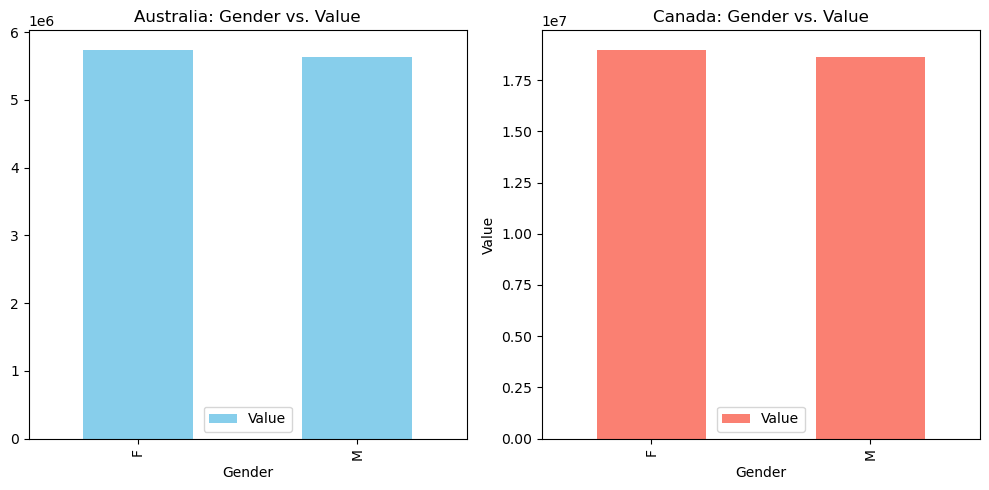

In [11]:
au_gender_vs_val = au_df.groupby(['Gender']).sum(['Value'])
can_gender_vs_val = can_df.groupby(['Gender']).sum(['Value'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

au_gender_vs_val.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Australia: Gender vs. Value')
plt.xlabel('Gender', rotation=0)  
plt.ylabel('Value', rotation=90) 

can_gender_vs_val.plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Canada: Gender vs. Value')
plt.xlabel('Gender', rotation=0)  
plt.ylabel('Value', rotation=90) 

# Adjust layout
plt.tight_layout()

**Observation:** Both datasets show near-equal representation between males and females, suggesting balanced sampling methods or low gender bias in data collection.

### Age Group vs. Value

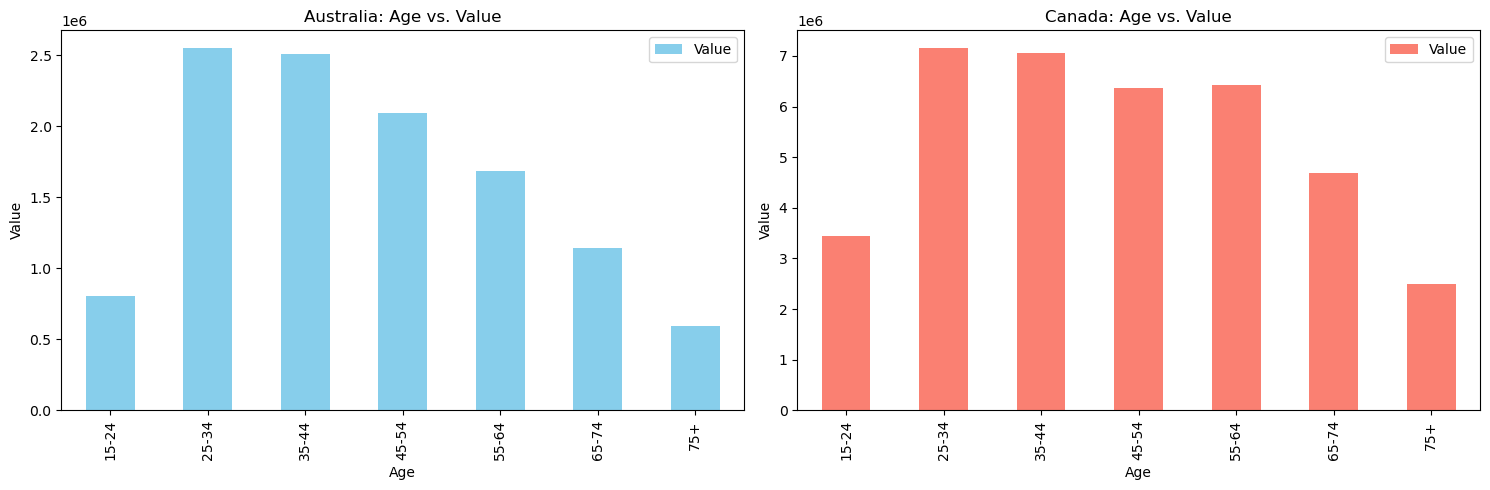

In [12]:
au_yr_vs_val = au_df.groupby(['Year']).sum(['Value'])
can_yr_vs_val = can_df.groupby(['Year']).sum(['Value'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

au_yr_vs_val.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Australia: Age vs. Value')
axes[0].set_xlabel('Age', rotation=0)  
axes[0].set_ylabel('Value', rotation=90) 

can_yr_vs_val.plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Canada: Age vs. Value')
axes[1].set_xlabel('Age', rotation=0)  
axes[1].set_ylabel('Value', rotation=90) 
plt.tight_layout()

**Observation:**
- Australia's sample is skewed towards ages 25-44.
- Canada shows a more even distribution across age groups.
- Both show low representation at the extremes (15-24 and 75+).

### Qualification Level vs. Value

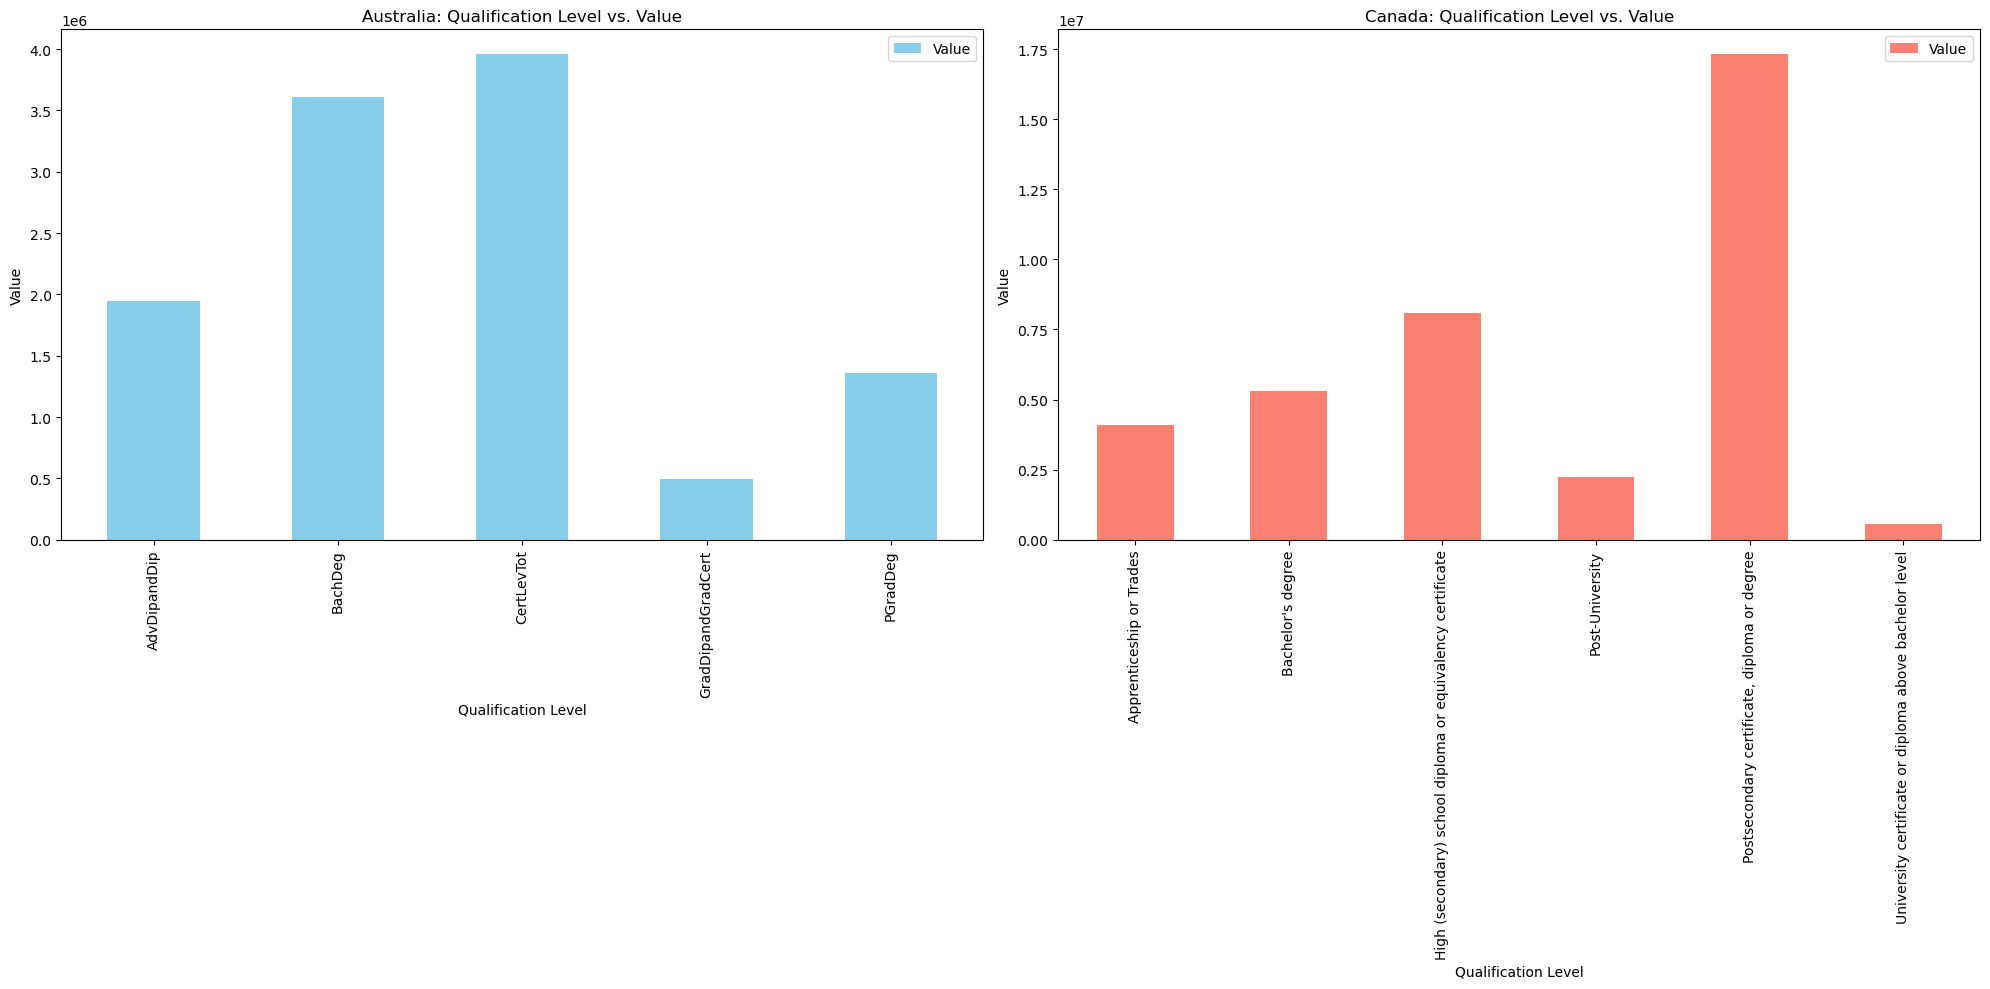

In [13]:
au_quallvl_vs_val = au_df.groupby(['Qualification Level']).sum(['Value'])
can_quallvl_vs_val = can_df.groupby(['Qualification Level']).sum(['Value'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

au_quallvl_vs_val.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Australia: Qualification Level vs. Value')
axes[0].set_xlabel('Qualification Level', rotation=0)  
axes[0].set_ylabel('Value', rotation=90) 

can_quallvl_vs_val.plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Canada: Qualification Level vs. Value')
axes[1].set_xlabel('Qualification Level', rotation=0)  
axes[1].set_ylabel('Value', rotation=90) 
plt.tight_layout()

**Observation:**
- Australia: Most individuals hold a Certificate Level or Bachelor Degree.
- Canada: Postsecondary qualifications dominate.
- Comparison suggests differing national education structures, but potential equivalences across levels.

### Gender x Qualification Level

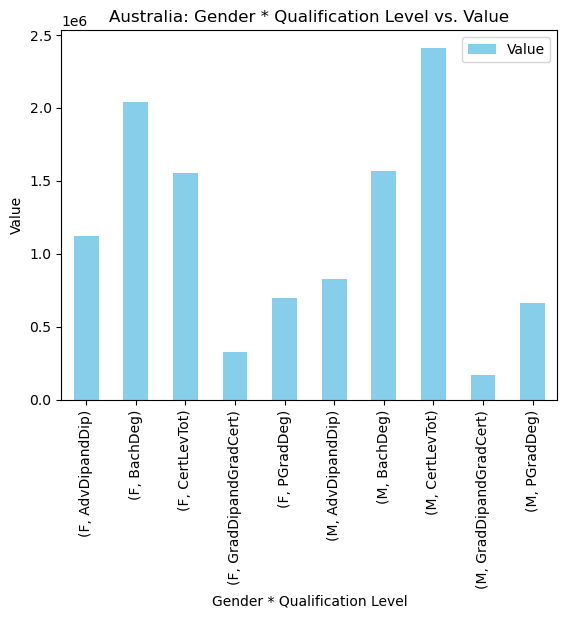

In [14]:
au_gen_qual_vs_val = au_df.groupby(['Gender','Qualification Level']).sum(['Value'])
au_gen_qual_vs_val.plot(kind='bar', color='skyblue')
plt.title('Australia: Gender * Qualification Level vs. Value')
plt.xlabel('Gender * Qualification Level')
plt.ylabel('Value')
plt.show()

**Key Takeaways (Australia):**
- Female counts surpass male in most qualification levels, except for *Certificate Level*.
- Male + Certificate Level combination has the highest individual count.

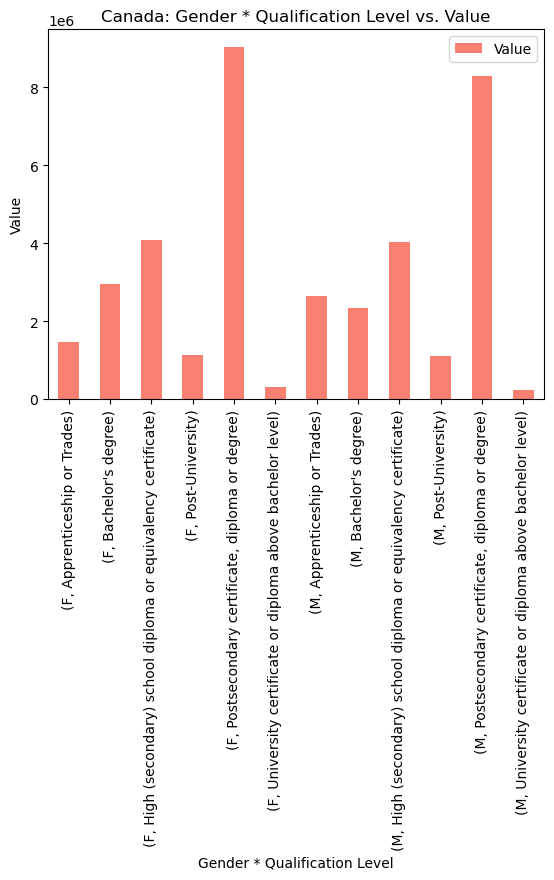

In [15]:
can_gen_qual_vs_val = can_df.groupby(['Gender','Qualification Level']).sum(['Value'])
can_gen_qual_vs_val.plot(kind='bar', color='salmon')
plt.title('Canada: Gender * Qualification Level vs. Value')
plt.xlabel('Gender * Qualification Level')
plt.ylabel('Value')
plt.show()

**Key Takeaways (Canada):**
- Less pronounced gender differences than in Australia.
- No clear gender dominance across qualification levels.

### Age x Qualification Level (Australia)

Text(0, 0.5, 'Value')

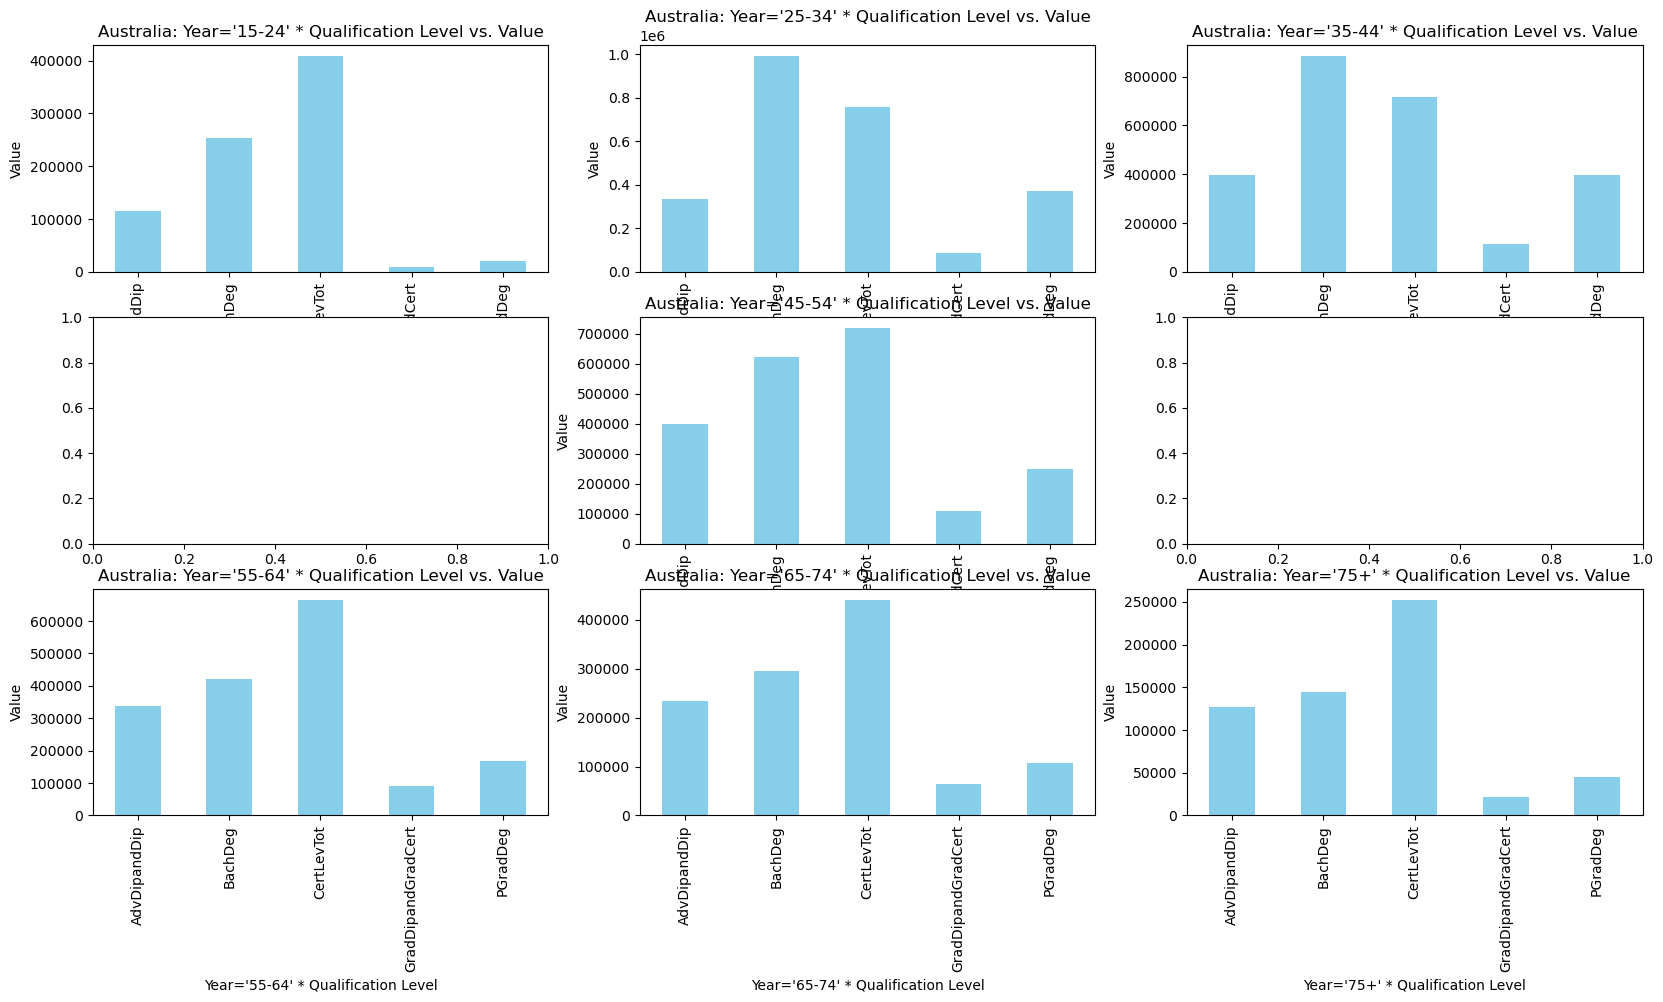

In [16]:
au_gen_age_vs_val = au_df.groupby(['Year','Qualification Level'])['Value'].sum()
au_gen_age_vs_val_1524 = au_gen_age_vs_val.loc['15-24']
au_gen_age_vs_val_2534 = au_gen_age_vs_val.loc['25-34']
au_gen_age_vs_val_3544 = au_gen_age_vs_val.loc['35-44']
au_gen_age_vs_val_4554 = au_gen_age_vs_val.loc['45-54']
au_gen_age_vs_val_5564 = au_gen_age_vs_val.loc['55-64']
au_gen_age_vs_val_6574 = au_gen_age_vs_val.loc['65-74']
au_gen_age_vs_val_75 = au_gen_age_vs_val.loc['75+']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))

au_gen_age_vs_val_1524.plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title("Australia: Year='15-24' * Qualification Level vs. Value")
axes[0,0].set_xlabel("Year='15-24' * Qualification Level", rotation=0)  
axes[0,0].set_ylabel('Value', rotation=90) 

au_gen_age_vs_val_2534.plot(kind='bar', ax=axes[0,1], color='skyblue')
axes[0,1].set_title("Australia: Year='25-34' * Qualification Level vs. Value")
axes[0,1].set_xlabel("Year='25-34' * Qualification Level", rotation=0)  
axes[0,1].set_ylabel('Value', rotation=90) 

au_gen_age_vs_val_3544.plot(kind='bar', ax=axes[0,2], color='skyblue')
axes[0,2].set_title("Australia: Year='35-44' * Qualification Level vs. Value")
axes[0,2].set_xlabel("Year='35-44' * Qualification Level", rotation=0)  
axes[0,2].set_ylabel('Value', rotation=90) 

au_gen_age_vs_val_4554.plot(kind='bar', ax=axes[1,1], color='skyblue')
axes[1,1].set_title("Australia: Year='45-54' * Qualification Level vs. Value")
axes[1,1].set_xlabel("Year='45-54' * Qualification Level", rotation=0)  
axes[1,1].set_ylabel('Value', rotation=90) 

au_gen_age_vs_val_5564.plot(kind='bar', ax=axes[2,0], color='skyblue')
axes[2,0].set_title("Australia: Year='55-64' * Qualification Level vs. Value")
axes[2,0].set_xlabel("Year='55-64' * Qualification Level", rotation=0)  
axes[2,0].set_ylabel('Value', rotation=90) 

au_gen_age_vs_val_6574.plot(kind='bar', ax=axes[2,1], color='skyblue')
axes[2,1].set_title("Australia: Year='65-74' * Qualification Level vs. Value")
axes[2,1].set_xlabel("Year='65-74' * Qualification Level", rotation=0)  
axes[2,1].set_ylabel('Value', rotation=90) 

au_gen_age_vs_val_75.plot(kind='bar', ax=axes[2,2], color='skyblue')
axes[2,2].set_title("Australia: Year='75+' * Qualification Level vs. Value")
axes[2,2].set_xlabel("Year='75+' * Qualification Level", rotation=0)  
axes[2,2].set_ylabel('Value', rotation=90) 


### Age x Qualification Level (Canada)

Text(0, 0.5, 'Value')

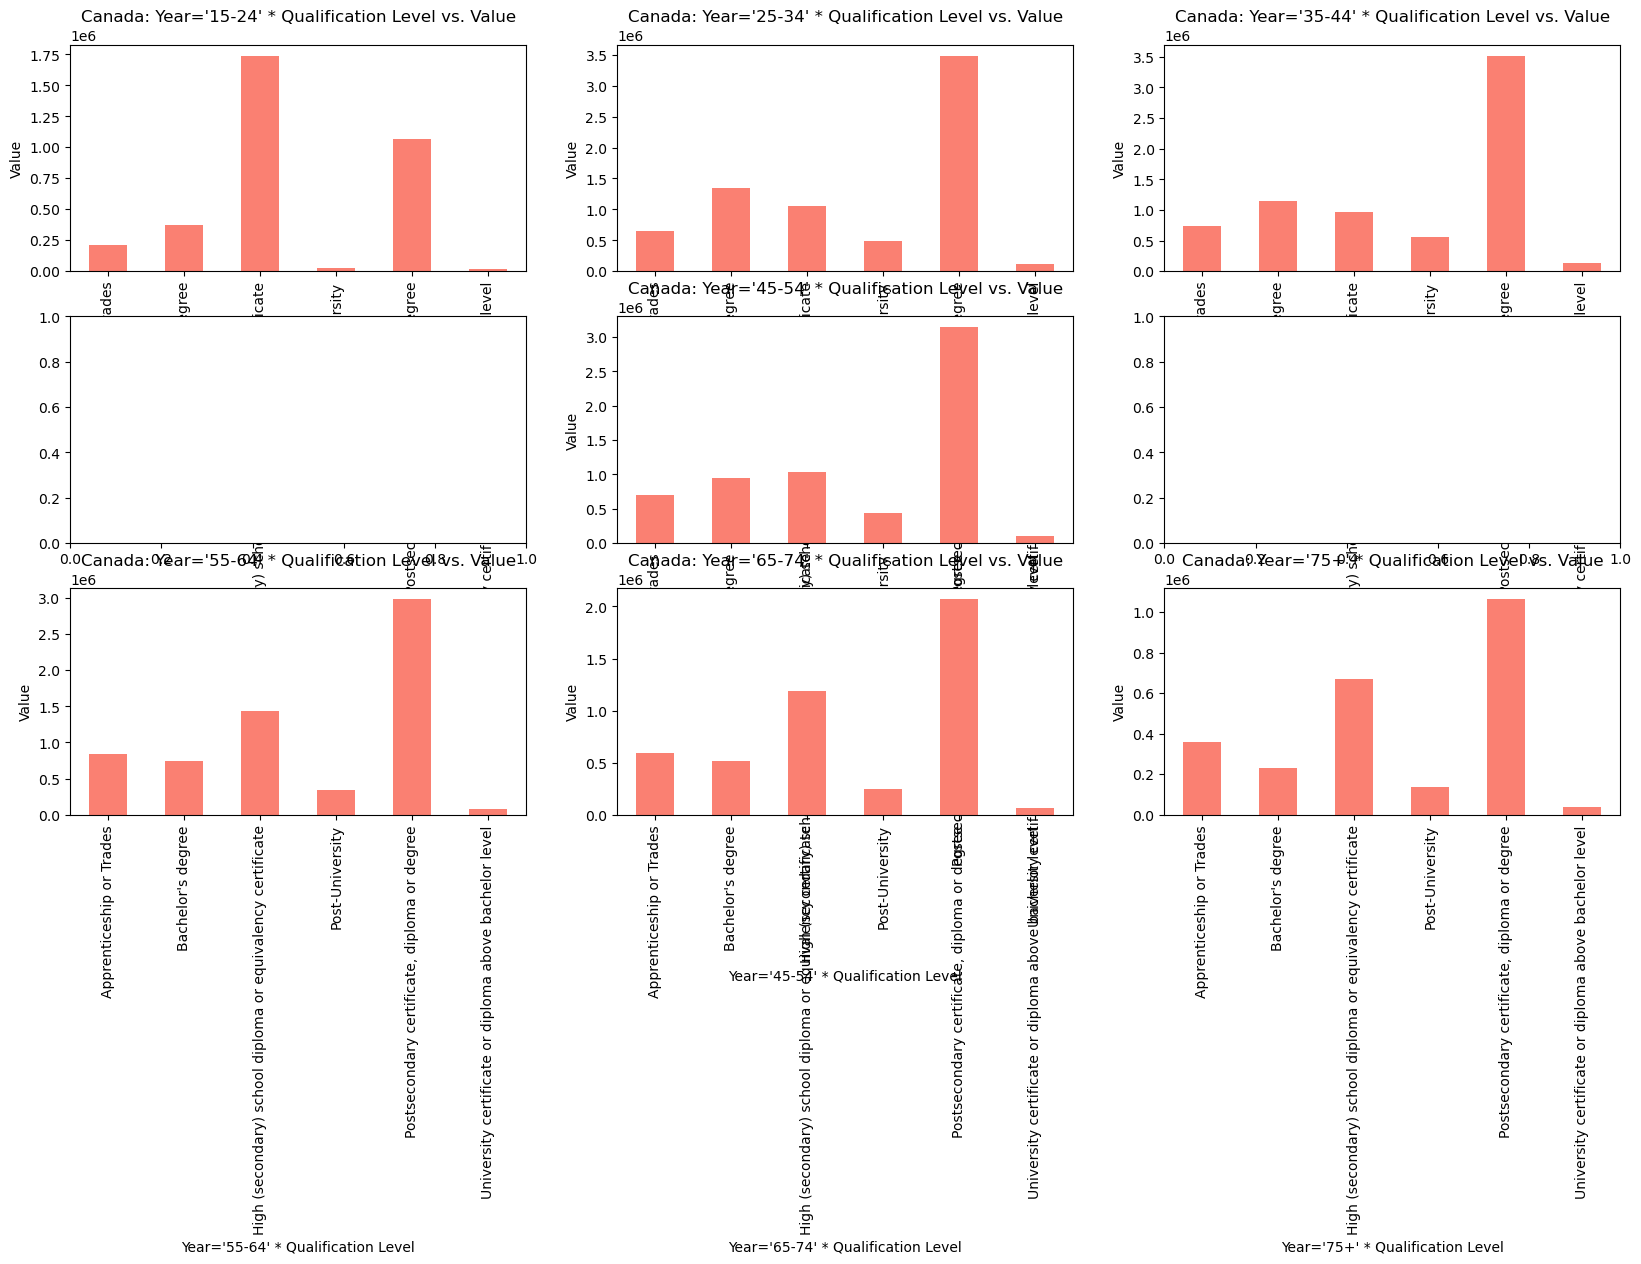

In [17]:
can_gen_age_vs_val = can_df.groupby(['Year','Qualification Level'])['Value'].sum()
can_gen_age_vs_val_1524 = can_gen_age_vs_val.loc['15-24']
can_gen_age_vs_val_2534 = can_gen_age_vs_val.loc['25-34']
can_gen_age_vs_val_3544 = can_gen_age_vs_val.loc['35-44']
can_gen_age_vs_val_4554 = can_gen_age_vs_val.loc['45-54']
can_gen_age_vs_val_5564 = can_gen_age_vs_val.loc['55-64']
can_gen_age_vs_val_6574 = can_gen_age_vs_val.loc['65-74']
can_gen_age_vs_val_75 = can_gen_age_vs_val.loc['75+']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))

can_gen_age_vs_val_1524.plot(kind='bar', ax=axes[0,0], color='salmon')
axes[0,0].set_title("Canada: Year='15-24' * Qualification Level vs. Value")
axes[0,0].set_xlabel("Year='15-24' * Qualification Level", rotation=0)  
axes[0,0].set_ylabel('Value', rotation=90) 

can_gen_age_vs_val_2534.plot(kind='bar', ax=axes[0,1], color='salmon')
axes[0,1].set_title("Canada: Year='25-34' * Qualification Level vs. Value")
axes[0,1].set_xlabel("Year='25-34' * Qualification Level", rotation=0)  
axes[0,1].set_ylabel('Value', rotation=90) 

can_gen_age_vs_val_3544.plot(kind='bar', ax=axes[0,2], color='salmon')
axes[0,2].set_title("Canada: Year='35-44' * Qualification Level vs. Value")
axes[0,2].set_xlabel("Year='35-44' * Qualification Level", rotation=0)  
axes[0,2].set_ylabel('Value', rotation=90) 

can_gen_age_vs_val_4554.plot(kind='bar', ax=axes[1,1], color='salmon')
axes[1,1].set_title("Canada: Year='45-54' * Qualification Level vs. Value")
axes[1,1].set_xlabel("Year='45-54' * Qualification Level", rotation=0)  
axes[1,1].set_ylabel('Value', rotation=90) 

can_gen_age_vs_val_5564.plot(kind='bar', ax=axes[2,0], color='salmon')
axes[2,0].set_title("Canada: Year='55-64' * Qualification Level vs. Value")
axes[2,0].set_xlabel("Year='55-64' * Qualification Level", rotation=0)  
axes[2,0].set_ylabel('Value', rotation=90) 

can_gen_age_vs_val_6574.plot(kind='bar', ax=axes[2,1], color='salmon')
axes[2,1].set_title("Canada: Year='65-74' * Qualification Level vs. Value")
axes[2,1].set_xlabel("Year='65-74' * Qualification Level", rotation=0)  
axes[2,1].set_ylabel('Value', rotation=90) 

can_gen_age_vs_val_75.plot(kind='bar', ax=axes[2,2], color='salmon')
axes[2,2].set_title("Canada: Year='75+' * Qualification Level vs. Value")
axes[2,2].set_xlabel("Year='75+' * Qualification Level", rotation=0)  
axes[2,2].set_ylabel('Value', rotation=90) 

**Key Takeaways:**
- No consistent pattern links age to higher education level.
- Educational attainment varies across age ranges without a clear upward trend.
- Gender differences in Australia are more pronounced than in Canada.
- Comparing education across nations requires normalization of category meanings.

## Conclusion:
At the start of this analysis, we set out to answer two central questions:
> 1. Is there a difference in the highest educational level achieved between both genders?
> 2. As the age of an individual increases, does that mean we can assume their highest educational attainment is high as well?

Using census data from Statistics Canada and the Australian Bureau of Statistics (ABS), we conducted a comparative analysis through cleaned datasets and visualizations.

### Key Findings
1. **Educational Attainment and Gender**
While some differences exist between male and female respondents within each country (e.g., females in Australia show higher counts in most levels except Certificate Level), ***we cannot confidently conclude that gender alone predicts educational attainment***. The distributions vary between the two countries and do not show a universal trend.
2. **Educational Attainment and Age**
Across both datasets, we observed that ***higher age does not consistently correspond to higher educational qualifications***. For example, mid-age ranges (25–44) often dominate in holding bachelor's or certificate-level qualifications, while older age groups do not show significantly higher attainment. This suggests no strong correlation between age and qualification level.

### Final Thoughts
Everyone pursues education for different reasons—career advancement, personal growth, access, or opportunity. This analysis supports the idea that neither age nor gender alone determines an individual's highest level of educational attainment. Instead, educational outcomes are influenced by a complex set of personal, societal, and institutional factors.